<a href="https://colab.research.google.com/github/adityagupta-9900/Car-Rental-Project/blob/master/ImgClass(FAI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd
from fastai import *
from fastai.vision import *
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [85]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


In [84]:
# !unzip drive/MyDrive/Assignment5/test_images.zip
# !unzip drive/MyDrive/Assignment5/train_images.zip
# !mkdir -p data/
# !mv test_images data/
# !mv train_images data/
# !rm -rf sample_data
# !cp ./drive/MyDrive/Assignment5/test.csv ./data/
# !cp ./drive/MyDrive/Assignment5/train.csv ./data/

In [57]:
data_folder = Path("./data")
train_labels = pd.read_csv("data/train.csv")
test_imageids = pd.read_csv("data/test.csv")

In [86]:
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.1, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

test_img = ImageList.from_df(test_imageids, path=data_folder/'test_images', folder='./')

train_images = (ImageList.from_df(train_labels, path=data_folder/'train_images', folder='./')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=216)
        .databunch(path='.', bs=61, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

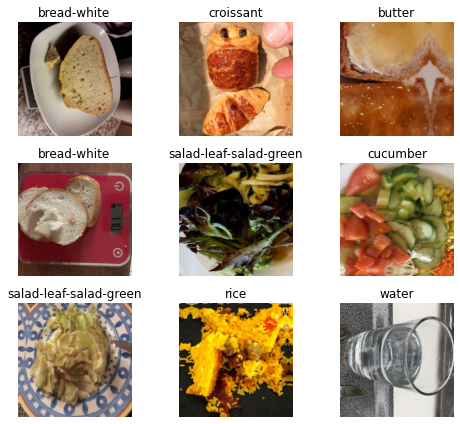

In [87]:
train_images.show_batch(rows=3, figsize=(7,6))

In [90]:
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(train_images, models.resnet50, metrics=[f_score,accuracy]) 

In [91]:
lr = 3e-02 
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,fbeta,accuracy,time


RuntimeError: ignored

In [70]:
learn.save('stage-1')
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


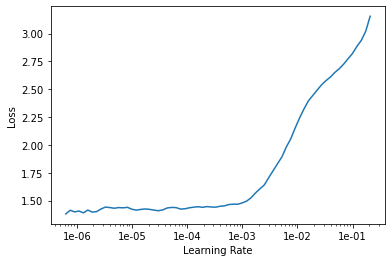

In [71]:
learn.lr_find()
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(5, slice(1e-5, lr/30))

epoch,train_loss,valid_loss,accuracy,time
0,1.446810,1.638716,0.548387,03:26
1,1.442163,1.658198,0.569892,03:29
2,1.333211,1.659666,0.483871,03:26
3,1.193955,1.501822,0.548387,03:31
4,1.090955,1.517615,0.569892,03:25


In [78]:
train_images = (ImageList.from_df(train_labels, path=data_folder/'train_images', folder='./')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=216)
        .databunch(path='.', bs=61, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

learn.data =train_images
learn.freeze()

In [76]:
learn.save('stage-2')

In [79]:
def get_preds(obj, learn, thresh = 15):
    labels = []
    for item in learn.data.c2i:
        labels.append(item)

    predictions = {}
    x=0
    for item in obj:
        acc= round(item.item(), 3)*100
        if acc > thresh:
            predictions[labels[x]] = acc
        x+=1
    predictions ={k: v for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse=True)}

    return predictions
result,_ = learn.get_preds(ds_type=DatasetType.Test)

In [80]:
labelled_preds = [ learn.data.classes[np.argmax(np.asarray(pred)) ] for pred in result]
test_imageids["ClassName"] = np.asarray(labelled_preds)[:]
test_imageids.to_csv('submission.csv', index=False)